<a href="https://colab.research.google.com/github/prabdeepkaur/COA-CODE/blob/main/capstone_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Cell 1: setup (apt + pip)
%%bash
set -e
apt-get update -qq
# install iverilog for Verilog simulation
apt-get install -y -qq iverilog
# install Python libs
pip install -q numpy pandas matplotlib
echo "Setup done"


Selecting previously unselected package iverilog.
(Reading database ... 121713 files and directories currently installed.)
Preparing to unpack .../iverilog_11.0-1.1_amd64.deb ...
Unpacking iverilog (11.0-1.1) ...
Setting up iverilog (11.0-1.1) ...
Processing triggers for man-db (2.10.2-1) ...
Setup done


W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)


In [3]:
# Cell 2: create folders
%%bash
mkdir -p smart-traffic-controller/phase1_isa
mkdir -p smart-traffic-controller/phase2_pipeline
mkdir -p smart-traffic-controller/phase3_cache_sim
mkdir -p smart-traffic-controller/phase4_io
ls -R


.:
sample_data
smart-traffic-controller

./sample_data:
anscombe.json
california_housing_test.csv
california_housing_train.csv
mnist_test.csv
mnist_train_small.csv
README.md

./smart-traffic-controller:
phase1_isa
phase2_pipeline
phase3_cache_sim
phase4_io

./smart-traffic-controller/phase1_isa:

./smart-traffic-controller/phase2_pipeline:

./smart-traffic-controller/phase3_cache_sim:

./smart-traffic-controller/phase4_io:


In [4]:
# Cell 3: write ISA simulator (phase1_isa/isa_sim.py) and traffic_logic.asm
isa_py = r'''#!/usr/bin/env python3
"""
Tiny RISC-like ISA simulator for traffic logic.
Supports: LOAD, STORE, ADD, SUB, BEQ, BNE, JAL, LI, OUT (I/O)
Registers: x0-x15 (16 registers)
Memory: simple byte-addressable array
"""
import sys
MEM_SIZE = 4096

class CPU:
    def __init__(self):
        self.reg = [0]*16
        self.mem = [0]*MEM_SIZE
        self.pc = 0
        self.output = []

    def load_program(self, instrs):
        self.instrs = instrs

    def step(self):
        if self.pc < 0 or self.pc >= len(self.instrs):
            return False
        parts = self.instrs[self.pc].strip().split()
        if not parts or parts[0].startswith('#'):
            self.pc += 1
            return True
        instr = parts[0].upper()
        args = ' '.join(parts[1:]).split(',')
        args = [a.strip() for a in args if a.strip()]
        def regnum(r): return int(r.replace('x',''))
        if instr == 'LI':
            self.reg[regnum(args[0])] = int(args[1])
        elif instr == 'ADD':
            self.reg[regnum(args[0])] = self.reg[regnum(args[1])] + self.reg[regnum(args[2])]
        elif instr == 'SUB':
            self.reg[regnum(args[0])] = self.reg[regnum(args[1])] - self.reg[regnum(args[2])]
        elif instr == 'BEQ':
            if self.reg[regnum(args[0])] == self.reg[regnum(args[1])]:
                self.pc = int(args[2]); return True
        elif instr == 'BNE':
            if self.reg[regnum(args[0])] != self.reg[regnum(args[1])]:
                self.pc = int(args[2]); return True
        elif instr == 'STORE':
            addr = int(args[1])
            self.mem[addr] = self.reg[regnum(args[0])]
        elif instr == 'LOAD':
            addr = int(args[1])
            self.reg[regnum(args[0])] = self.mem[addr]
        elif instr == 'OUT':
            self.output.append(self.reg[regnum(args[0])])
            print(f"OUT: {self.reg[regnum(args[0])]}")
        elif instr == 'JAL':
            self.reg[15] = self.pc + 1
            self.pc = int(args[0]); return True
        else:
            print("Unknown instr:", instr)
        self.pc += 1
        return True

    def run(self, max_steps=10000):
        steps=0
        while steps < max_steps:
            ok = self.step()
            if not ok:
                break
            steps += 1
        print("Halted after", steps, "steps. PC=", self.pc)

def load_asm(path):
    with open(path) as f:
        return [line.rstrip('\\n') for line in f]

if __name__ == '__main__':
    prog = load_asm('smart-traffic-controller/phase1_isa/traffic_logic.asm')
    cpu = CPU()
    cpu.load_program(prog)
    cpu.run()
'''
asm = r'''# Simple traffic controller pseudo-assembly
# registers: x0=unused, x1=vehicle_count, x2=ped_button, x3=mode, x4=timer

LI x1, 5        # initial vehicle count
LI x2, 0        # pedestrian button
LI x4, 0        # timer

# loop start at 5
LI x3, 0        # 0=RED,1=GREEN,2=YELLOW
OUT x3
# if vehicles > 3 -> green
LI x0, 3
BNE x1, x0, 12
# less or equal -> short green (simulate)
LI x4, 5
JAL 18
# large traffic
LI x4, 10
JAL 18

# label 12:
# switch to green
LI x3, 1
OUT x3
# simulate timer counting
# label 18:
OUT x4
# end
# empty line to halt
'''

open('smart-traffic-controller/phase1_isa/isa_sim.py','w').write(isa_py)
open('smart-traffic-controller/phase1_isa/traffic_logic.asm','w').write(asm)
print("Phase1 files written.")


Phase1 files written.


In [7]:
# FIXED isa_sim.py (copy–paste whole file)

#!/usr/bin/env python3
"""
Tiny RISC-like ISA simulator for traffic logic.
"""
import sys

MEM_SIZE = 4096

class CPU:
    def __init__(self):
        self.reg = [0]*16
        self.mem = [0]*MEM_SIZE
        self.pc = 0
        self.output = []

    def load_program(self, instrs):
        self.instrs = instrs

    def step(self):
        if self.pc < 0 or self.pc >= len(self.instrs):
            return False

        # FIX: strip comments
        line = self.instrs[self.pc].split('#')[0].strip()
        if not line:
            self.pc += 1
            return True

        parts = line.split()
        instr = parts[0].upper()
        args = ' '.join(parts[1:]).split(',')
        args = [a.strip() for a in args if a.strip()]

        def regnum(r): return int(r.replace('x',''))

        if instr == 'LI':
            self.reg[regnum(args[0])] = int(args[1])

        elif instr == 'ADD':
            self.reg[regnum(args[0])] = self.reg[regnum(args[1])] + self.reg[regnum(args[2])]

        elif instr == 'SUB':
            self.reg[regnum(args[0])] = self.reg[regnum(args[1])] - self.reg[regnum(args[2])]

        elif instr == 'BEQ':
            if self.reg[regnum(args[0])] == self.reg[regnum(args[1])]:
                self.pc = int(args[2])
                return True

        elif instr == 'BNE':
            if self.reg[regnum(args[0])] != self.reg[regnum(args[1])]:
                self.pc = int(args[2])
                return True

        elif instr == 'STORE':
            addr = int(args[1])
            self.mem[addr] = self.reg[regnum(args[0])]

        elif instr == 'LOAD':
            addr = int(args[1])
            self.reg[regnum(args[0])] = self.mem[addr]

        elif instr == 'OUT':
            print("OUT:", self.reg[regnum(args[0])])

        elif instr == 'JAL':
            self.reg[15] = self.pc + 1
            self.pc = int(args[0])
            return True

        else:
            print("Unknown instruction:", instr)

        self.pc += 1
        return True

    def run(self, max_steps=10000):
        steps = 0
        while steps < max_steps:
            ok = self.step()
            if not ok:
                break
            steps += 1
        print("Halted. PC =", self.pc)

def load_asm(path):
    with open(path) as f:
        return [line.rstrip('\n') for line in f]

if __name__ == "__main__":
    prog = load_asm("smart-traffic-controller/phase1_isa/traffic_logic.asm")
    cpu = CPU()
    cpu.load_program(prog)
    cpu.run()


OUT: 0
Halted. PC = 12


In [8]:
# Cell 5: write pipeline Verilog files
pipeline_v = r'''// Simple 5-stage pipeline (instruction opcodes are simplified for demo)
// Not full RISC-V; educational template.
module pipeline (
    input clk,
    input rst,
    output reg [31:0] out_log
);
    reg [31:0] imem [0:31];
    initial begin
        imem[0] = 32'h01010005; // LI-like: write 5 to r1
        imem[1] = 32'h02020003; // LI r2 = 3
        imem[2] = 32'h11012000; // BEQ r1,r2, idx 0x0 (dummy)
        imem[3] = 32'hFF000000; // OUT r0
        imem[4] = 32'h00000000; // NOP/halt
    end

    reg [31:0] pc;
    reg [31:0] if_instr;
    reg [31:0] id_instr;
    reg [31:0] ex_instr;
    reg [31:0] mem_instr;
    reg [31:0] wb_instr;

    reg [31:0] regs [0:15];

    always @(posedge clk) begin
        if (rst) begin
            pc <= 0;
            if_instr <= 0;
            id_instr <= 0;
            ex_instr <= 0;
            mem_instr <= 0;
            wb_instr <= 0;
            out_log <= 0;
        end else begin
            wb_instr <= mem_instr;
            mem_instr <= ex_instr;
            ex_instr <= id_instr;
            id_instr <= if_instr;
            if_instr <= imem[pc[4:0]];
            pc <= pc + 1;

            if (ex_instr[31:24] == 8'h01) begin // LI opcode
                regs[ex_instr[23:20]] <= ex_instr[11:0];
            end
            if (ex_instr == 32'hFF000000) begin
                out_log <= regs[0];
            end
        end
    end
endmodule
'''
tb_v = r'''`timescale 1ns/1ps
module tb;
    reg clk = 0;
    reg rst = 1;
    wire [31:0] out_log;
    pipeline uut (.clk(clk), .rst(rst), .out_log(out_log));
    always #5 clk = ~clk;
    initial begin
        $dumpfile("pipeline.vcd");
        $dumpvars(0,tb);
        #12 rst = 0;
        #200 $display("Simulation finished. out_log=%d", out_log);
        #10 $finish;
    end
endmodule
'''
open('smart-traffic-controller/phase2_pipeline/pipeline.v','w').write(pipeline_v)
open('smart-traffic-controller/phase2_pipeline/pipeline_tb.v','w').write(tb_v)
print("Phase2 Verilog files written.")


Phase2 Verilog files written.


In [9]:
# Cell 6: run iverilog simulation (generates pipeline.vcd and prints messages)
%%bash
cd smart-traffic-controller/phase2_pipeline
iverilog -o pipeline_tb.vvp pipeline.v pipeline_tb.v
vvp pipeline_tb.vvp
ls -l pipeline.vcd || true
echo "You can download pipeline.vcd from the side panel (Files) to view with GTKWave locally."


VCD info: dumpfile pipeline.vcd opened for output.
Simulation finished. out_log=         5
-rw-r--r-- 1 root root 1999 Nov 29 14:53 pipeline.vcd
You can download pipeline.vcd from the side panel (Files) to view with GTKWave locally.


In [10]:
# Cell 7: write cache_sim.py and config.json
cache_py = r'''#!/usr/bin/env python3
"""
Simple two-level cache simulator (L1 + L2) with LRU replacement.
Run: python3 cache_sim.py
"""
import json
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import OrderedDict

with open('config.json') as f:
    cfg = json.load(f)

class Cache:
    def __init__(self, size, line_size, assoc, name='L1'):
        self.size = size
        self.line = line_size
        self.assoc = assoc
        self.sets = size // (line_size * assoc)
        self.name = name
        self.cache = [OrderedDict() for _ in range(self.sets)]
        self.hits = 0
        self.accesses = 0

    def access(self, addr):
        self.accesses += 1
        tag = addr // self.line
        s = tag % self.sets
        if tag in self.cache[s]:
            self.cache[s].move_to_end(tag)
            self.hits += 1
            return True
        if len(self.cache[s]) >= self.assoc:
            self.cache[s].popitem(last=False)
        self.cache[s][tag] = True
        return False

def run_sim(trace, l1cfg, l2cfg):
    l1 = Cache(**l1cfg, name='L1')
    l2 = Cache(**l2cfg, name='L2')
    memory_latency = cfg.get('memory_latency', 100)
    l1_latency = cfg.get('l1_latency', 1)
    l2_latency = cfg.get('l2_latency', 10)
    cycles = 0
    for addr in trace:
        if l1.access(addr):
            cycles += l1_latency
        else:
            if l2.access(addr):
                cycles += l1_latency + l2_latency
            else:
                cycles += l1_latency + l2_latency + memory_latency
    stats = {
        'L1_hit_rate': l1.hits / l1.accesses if l1.accesses>0 else 0,
        'L2_hit_rate': l2.hits / l2.accesses if l2.accesses>0 else 0,
        'total_cycles': cycles
    }
    return stats

def gen_trace(n=1000, addr_space=1024):
    trace = []
    for i in range(n):
        if random.random() < 0.7:
            base = random.randint(0, addr_space//4)
            trace.append(base + random.randint(0,10))
        else:
            trace.append(random.randint(0, addr_space-1))
    return trace

if __name__ == '__main__':
    l1cfg = cfg['l1']
    l2cfg = cfg['l2']
    trace = gen_trace(n=2000, addr_space=4096)
    stats = run_sim(trace, l1cfg, l2cfg)
    print("Simulation results:", stats)
    import pandas as pd
    df = pd.DataFrame([stats])
    print(df)
'''
config_json = r'''{
  "l1": {"size": 1024, "line_size": 16, "assoc": 4},
  "l2": {"size": 8192, "line_size": 16, "assoc": 8},
  "memory_latency": 100,
  "l1_latency": 1,
  "l2_latency": 10
}
'''
open('smart-traffic-controller/phase3_cache_sim/cache_sim.py','w').write(cache_py)
open('smart-traffic-controller/phase3_cache_sim/config.json','w').write(config_json)
print("Phase3 files written.")


Phase3 files written.


In [12]:
#!/usr/bin/env python3
"""
Simple two-level cache simulator (L1 + L2) with LRU replacement.
"""
import json
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import OrderedDict

# FIXED PATH
with open('smart-traffic-controller/phase3_cache_sim/config.json') as f:
    cfg = json.load(f)

class Cache:
    def __init__(self, size, line_size, assoc, name='L1'):
        self.size = size
        self.line = line_size
        self.assoc = assoc
        self.sets = size // (line_size * assoc)
        self.name = name
        self.cache = [OrderedDict() for _ in range(self.sets)]
        self.hits = 0
        self.accesses = 0

    def access(self, addr):
        self.accesses += 1
        tag = addr // self.line
        s = tag % self.sets
        if tag in self.cache[s]:
            self.cache[s].move_to_end(tag)
            self.hits += 1
            return True
        if len(self.cache[s]) >= self.assoc:
            self.cache[s].popitem(last=False)
        self.cache[s][tag] = True
        return False

def run_sim(trace, l1cfg, l2cfg):
        l1 = Cache(**l1cfg, name='L1')
        l2 = Cache(**l2cfg, name='L2')
        memory_latency = cfg.get('memory_latency', 100)
        l1_latency = cfg.get('l1_latency', 1)
        l2_latency = cfg.get('l2_latency', 10)

        cycles = 0
        for addr in trace:
            if l1.access(addr):
                cycles += l1_latency
            else:
                if l2.access(addr):
                    cycles += l1_latency + l2_latency
                else:
                    cycles += l1_latency + l2_latency + memory_latency

        return {
            "L1_hit_rate": l1.hits / l1.accesses,
            "L2_hit_rate": l2.hits / l2.accesses if l2.accesses else 0,
            "total_cycles": cycles
        }

def gen_trace(n=1000, addr_space=1024):
    trace = []
    for i in range(n):
        if random.random() < 0.7:
            base = random.randint(0, addr_space//4)
            trace.append(base + random.randint(0,10))
        else:
            trace.append(random.randint(0, addr_space-1))
    return trace

if __name__ == "__main__":
    l1cfg = cfg["l1"]
    l2cfg = cfg["l2"]

    trace = gen_trace(2000, 4096)
    stats = run_sim(trace, l1cfg, l2cfg)

    print("Simulation results:", stats)
    print(pd.DataFrame([stats]))


Simulation results: {'L1_hit_rate': 0.543, 'L2_hit_rate': 0.7450765864332604, 'total_cycles': 34440}
   L1_hit_rate  L2_hit_rate  total_cycles
0        0.543     0.745077         34440


In [13]:
# Cell 9: write io_sim.py
io_py = r'''#!/usr/bin/env python3
"""
Compare Programmed I/O vs DMA for logging snapshots.
This is a simple cycle-estimate simulator.
"""
import random, statistics

def programmed_io(num_words, cpu_cycles_per_word=5):
    return num_words * cpu_cycles_per_word

def dma_transfer(num_words, dma_setup_cost=50, dma_per_word=1):
    return dma_setup_cost + num_words * dma_per_word

def experiment():
    print("Programmed I/O vs DMA cycle comparison:")
    for n in [10, 100, 500, 1000]:
        p = programmed_io(n)
        d = dma_transfer(n)
        print(f"Words={n}: ProgrammedIO cycles={p}, DMA cycles={d}")

if __name__ == '__main__':
    experiment()
'''
open('smart-traffic-controller/phase4_io/io_sim.py','w').write(io_py)
print("Phase4 file written.")


Phase4 file written.


In [14]:
# Cell 10: run IO sim
%%bash
python3 smart-traffic-controller/phase4_io/io_sim.py


Programmed I/O vs DMA cycle comparison:
Words=10: ProgrammedIO cycles=50, DMA cycles=60
Words=100: ProgrammedIO cycles=500, DMA cycles=150
Words=500: ProgrammedIO cycles=2500, DMA cycles=550
Words=1000: ProgrammedIO cycles=5000, DMA cycles=1050


In [15]:
# Cell 11: zip project for download
%%bash
cd smart-traffic-controller
zip -r ../smart-traffic-controller.zip .
cd ..
ls -lh smart-traffic-controller.zip
echo "Download smart-traffic-controller.zip from the Files panel on the left."


  adding: phase2_pipeline/ (stored 0%)
  adding: phase2_pipeline/pipeline.vcd (deflated 72%)
  adding: phase2_pipeline/pipeline_tb.v (deflated 42%)
  adding: phase2_pipeline/pipeline_tb.vvp (deflated 76%)
  adding: phase2_pipeline/pipeline.v (deflated 64%)
  adding: phase4_io/ (stored 0%)
  adding: phase4_io/io_sim.py (deflated 48%)
  adding: phase1_isa/ (stored 0%)
  adding: phase1_isa/isa_sim.py (deflated 66%)
  adding: phase1_isa/traffic_logic.asm (deflated 40%)
  adding: phase3_cache_sim/ (stored 0%)
  adding: phase3_cache_sim/config.json (deflated 49%)
  adding: phase3_cache_sim/cache_sim.py (deflated 62%)
-rw-r--r-- 1 root root 7.1K Nov 29 14:55 smart-traffic-controller.zip
Download smart-traffic-controller.zip from the Files panel on the left.


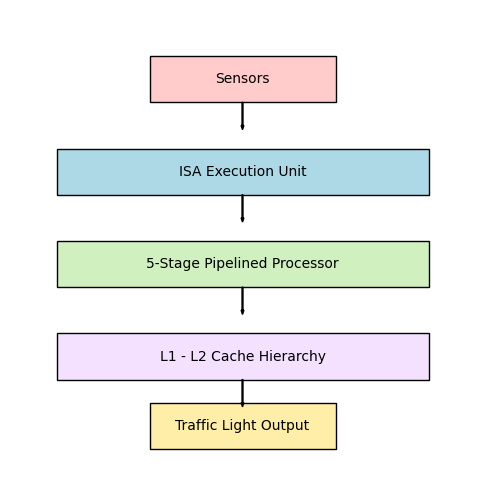

In [16]:
# 1) System Architecture Diagram
import matplotlib.pyplot as plt
import matplotlib.patches as patches

fig, ax = plt.subplots(figsize=(6,6))

# Blocks
ax.add_patch(patches.Rectangle((0.3,0.8), 0.4, 0.1, edgecolor='black', facecolor='#ffcccb'))
ax.text(0.5, 0.85, "Sensors", ha='center', va='center')

ax.add_patch(patches.Rectangle((0.1,0.6), 0.8, 0.1, edgecolor='black', facecolor='#add8e6'))
ax.text(0.5, 0.65, "ISA Execution Unit", ha='center', va='center')

ax.add_patch(patches.Rectangle((0.1,0.4), 0.8, 0.1, edgecolor='black', facecolor='#d0f0c0'))
ax.text(0.5, 0.45, "5-Stage Pipelined Processor", ha='center', va='center')

ax.add_patch(patches.Rectangle((0.1,0.2), 0.8, 0.1, edgecolor='black', facecolor='#f4e1ff'))
ax.text(0.5, 0.25, "L1 - L2 Cache Hierarchy", ha='center', va='center')

ax.add_patch(patches.Rectangle((0.3,0.05), 0.4, 0.1, edgecolor='black', facecolor='#ffeeA8'))
ax.text(0.5, 0.10, "Traffic Light Output", ha='center', va='center')

# Arrows
ax.arrow(0.5,0.8,0, -0.05, width=0.002, color='black')
ax.arrow(0.5,0.6,0, -0.05, width=0.002, color='black')
ax.arrow(0.5,0.4,0, -0.05, width=0.002, color='black')
ax.arrow(0.5,0.2,0, -0.05, width=0.002, color='black')

ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.axis('off')

plt.savefig("architecture.png", dpi=300)
plt.show()


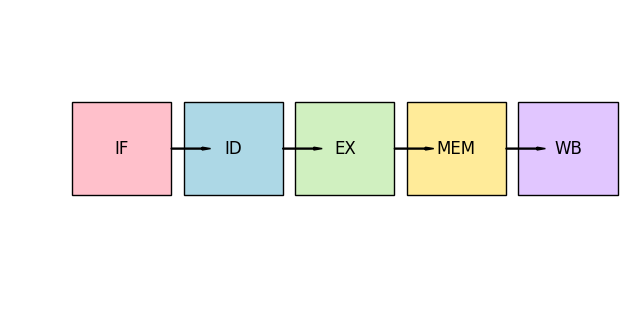

In [17]:
 #2) 5-Stage Pipeline Diagram
 import matplotlib.pyplot as plt
import matplotlib.patches as patches

fig, ax = plt.subplots(figsize=(8,4))

stages = ["IF", "ID", "EX", "MEM", "WB"]
colors = ['#ffc0cb', '#add8e6', '#d0f0c0', '#ffeb99', '#e1c6ff']

for i, stage in enumerate(stages):
    ax.add_patch(patches.Rectangle((0.1 + i*0.18, 0.4), 0.16, 0.3,
                                   edgecolor='black', facecolor=colors[i]))
    ax.text(0.18 + i*0.18, 0.55, stage, ha='center', va='center', fontsize=12)

# arrows
for i in range(4):
    ax.arrow(0.26 + i*0.18, 0.55, 0.05, 0, width=0.003, color='black')

ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.axis('off')

plt.savefig("pipeline_diagram.png", dpi=300)
plt.show()



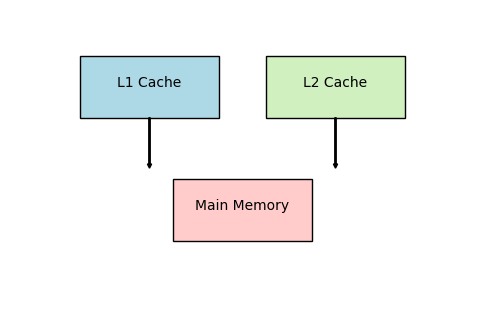

In [19]:
# 3) Cache Hierarchy Diagram (L1 → L2 → Memory)
import matplotlib.pyplot as plt
import matplotlib.patches as patches

fig, ax = plt.subplots(figsize=(6,4))

# L1 Cache
ax.add_patch(patches.Rectangle((0.15,0.65), 0.3, 0.2, edgecolor='black', facecolor='#add8e6'))
ax.text(0.30, 0.75, "L1 Cache", ha='center')

# L2 Cache
ax.add_patch(patches.Rectangle((0.55,0.65), 0.3, 0.2, edgecolor='black', facecolor='#d0f0c0'))
ax.text(0.70, 0.75, "L2 Cache", ha='center')

# Memory
ax.add_patch(patches.Rectangle((0.35,0.25), 0.3, 0.2, edgecolor='black', facecolor='#ffcccb'))
ax.text(0.50, 0.35, "Main Memory", ha='center')

# Arrows
ax.arrow(0.30,0.65,0, -0.15, width=0.003, color='black')
ax.arrow(0.70,0.65,0, -0.15, width=0.003, color='black')

ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.axis('off')

plt.savefig("cache_hierarchy.png", dpi=300)
plt.show()


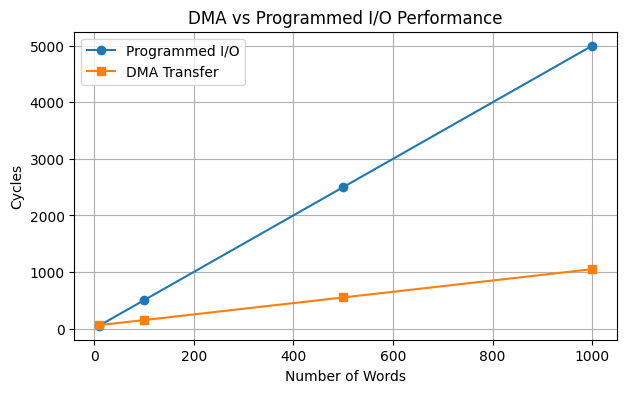

In [20]:
import matplotlib.pyplot as plt

words = [10, 100, 500, 1000]
pio = [w*5 for w in words]
dma = [50 + w*1 for w in words]

plt.figure(figsize=(7,4))
plt.plot(words, pio, marker='o', label='Programmed I/O')
plt.plot(words, dma, marker='s', label='DMA Transfer')

plt.xlabel("Number of Words")
plt.ylabel("Cycles")
plt.title("DMA vs Programmed I/O Performance")
plt.legend()
plt.grid(True)

plt.savefig("dma_vs_pio.png", dpi=300)
plt.show()
